# Panel Analysis with County Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
DATA_DIR = "../data/cleaned-data/"

In [3]:
data = pd.read_csv(DATA_DIR + "countyincome_gini_const.csv")
data.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
0,1989,1001,0.400131,13674.0,31869.0,333060.0,279230.0,3115.0,13269.0,295614.0
1,1989,1003,0.425340,39202.0,86819.0,957370.0,673040.0,24108.0,82778.0,779926.0
2,1989,1005,0.480382,9367.0,21385.0,193510.0,153190.0,2729.0,12946.0,168865.0
3,1989,1007,0.452399,6347.0,15087.0,129680.0,107400.0,924.0,5794.0,114118.0
4,1989,1009,0.419520,13270.0,31010.0,294430.0,241690.0,1984.0,14595.0,258269.0


In [4]:
error_geofips = []
for col in data.columns:
    error_geofips += list(data[data[col] <= 0]["GEOFIPS"])
error_geofips = list(set(error_geofips))
error_geofips

[31009,
 16033,
 46017,
 51685,
 38087,
 51049,
 31115,
 48269,
 16047,
 18101,
 48311,
 20089]

In [5]:
data = data[np.invert(data["GEOFIPS"].isin(error_geofips))]
data.shape

(94581, 10)

## Prepare Data

In [6]:
aggregate = pd.DataFrame(data.groupby("YEAR")[["TAXABLE_TOTAL", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST"]].sum()).reset_index()
aggregate.rename(columns={"TAXABLE_TOTAL": "AGGREGATE_TAXABLE_TOTAL", 
                          "AGI": "AGGREGATE_AGI", 
                          "WAGES_SALARIES": "AGGREGATE_WAGES_SALARIES", 
                          "DIVIDENDS": "AGGREGATE_DIVIDENDS", 
                          "INTEREST": "AGGREGATE_INTEREST"}, inplace=True)

In [7]:
data = data.merge(aggregate, left_on="YEAR", right_on="YEAR")

In [8]:
data_change = data.sort_values(by=["GEOFIPS", "YEAR"], ascending=True).set_index(["YEAR", "GEOFIPS", "GINI"]).pct_change().reset_index()
data_change = data_change[data_change["YEAR"] > 1989]
data_change

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
1,1990,1001,0.400131,-0.057847,-0.011861,0.046334,0.053898,-0.226966,0.021705,0.049494,-0.123073,-0.309019,-0.141230,0.008563,0.063839
2,1991,1001,0.400131,0.027090,0.026388,0.072343,0.061156,0.191445,0.002213,0.059592,0.019234,0.020797,0.028003,-0.030873,-0.054807
3,1992,1001,0.400131,0.016551,0.017388,0.071576,0.071366,-0.008714,-0.143814,0.061774,0.038077,0.054306,0.058766,0.008214,-0.180679
4,1993,1001,0.400131,0.039402,0.033968,0.059955,0.061450,0.157876,-0.146910,0.055292,0.020228,0.027664,0.031260,0.043717,-0.145406
5,1994,1001,0.400131,0.030184,0.019117,0.104980,0.071615,0.070452,0.011689,0.069990,0.043472,0.047956,0.048196,0.018019,-0.026120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94576,2015,56045,0.421600,-0.006042,-0.015291,0.017900,0.020256,-0.222190,-0.178397,0.012770,0.044352,0.039111,0.046528,0.001951,-0.003726
94577,2016,56045,0.410900,-0.045593,-0.035714,-0.134465,-0.113626,0.050433,0.014419,-0.109729,0.014741,0.004504,0.015445,-0.011257,0.030958
94578,2017,56045,0.410900,-0.015924,-0.012882,-0.047289,-0.003628,0.082408,1.152174,0.008472,0.051849,0.074555,0.049200,0.108694,0.108404
94579,2018,56045,0.410900,0.000000,-0.009788,0.027848,0.031129,-0.166170,-0.242813,0.021506,0.047992,0.057876,0.042559,0.143275,0.198122


In [9]:
cols = ["NUM_RETURN", "NUM_EXEMPT", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL", 
        "AGGREGATE_TAXABLE_TOTAL", "AGGREGATE_AGI", "AGGREGATE_WAGES_SALARIES", "AGGREGATE_DIVIDENDS", "AGGREGATE_INTEREST"]
for col in cols:
    data_change[col] = data_change[col].map(lambda x: x * 100)
data_change

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
1,1990,1001,0.400131,-5.784701,-1.186106,4.633399,5.389822,-22.696629,2.170473,4.949360,-12.307316,-30.901946,-14.123012,0.856282,6.383944
2,1991,1001,0.400131,2.708996,2.638849,7.234312,6.115604,19.144518,0.221288,5.959161,1.923444,2.079702,2.800259,-3.087279,-5.480742
3,1992,1001,0.400131,1.655079,1.738754,7.157556,7.136613,-0.871384,-14.381394,6.177354,3.807745,5.430620,5.876627,0.821441,-18.067890
4,1993,1001,0.400131,3.940227,3.396789,5.995490,6.145031,15.787623,-14.690965,5.529166,2.022772,2.766388,3.126031,4.371680,-14.540557
5,1994,1001,0.400131,3.018382,1.911708,10.498045,7.161483,7.045247,1.168884,6.998987,4.347175,4.795611,4.819628,1.801914,-2.611980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94576,2015,56045,0.421600,-0.604230,-1.529052,1.789975,2.025623,-22.218970,-17.839721,1.276999,4.435159,3.911094,4.652777,0.195135,-0.372631
94577,2016,56045,0.410900,-4.559271,-3.571429,-13.446539,-11.362599,5.043282,1.441900,-10.972930,1.474106,0.450449,1.544481,-1.125657,3.095825
94578,2017,56045,0.410900,-1.592357,-1.288245,-4.728889,-0.362815,8.240774,115.217391,0.847249,5.184895,7.455546,4.920041,10.869439,10.840437
94579,2018,56045,0.410900,0.000000,-0.978793,2.784802,3.112898,-16.617014,-24.281274,2.150617,4.799178,5.787627,4.255853,14.327542,19.812232


In [10]:
data_change.shape

(91530, 15)

In [11]:
cols = ['NUM_RETURN', 'NUM_EXEMPT', 'AGI',
       'WAGES_SALARIES', 'DIVIDENDS', 'INTEREST', 'TAXABLE_TOTAL']
outlier_idx = []

for col in cols:
    outlier_idx += list(data_change[(data_change[col] < -50.0) | (data_change[col] > 100.0)].index)

outlier_idx = list(set(outlier_idx))
outlier_idx

[81923,
 90141,
 16414,
 90165,
 81978,
 90170,
 90171,
 49220,
 49221,
 8264,
 8265,
 32844,
 32851,
 65619,
 65620,
 49242,
 49243,
 90202,
 16479,
 49248,
 16481,
 99,
 49251,
 49252,
 8298,
 8300,
 32877,
 113,
 24699,
 24700,
 49279,
 32898,
 32899,
 41095,
 24712,
 24713,
 90255,
 65682,
 82078,
 73893,
 8360,
 41129,
 32943,
 32944,
 32945,
 32946,
 82109,
 82110,
 73926,
 41159,
 73928,
 32974,
 32975,
 32976,
 32977,
 57550,
 57551,
 24790,
 16602,
 16604,
 82140,
 82142,
 82143,
 8423,
 8424,
 82156,
 33005,
 33006,
 33007,
 33008,
 73969,
 73972,
 82171,
 82177,
 24846,
 82202,
 74017,
 41250,
 41251,
 8484,
 8486,
 82214,
 82215,
 33070,
 65859,
 24901,
 24902,
 16724,
 82264,
 347,
 74113,
 8578,
 8577,
 8579,
 65921,
 74120,
 57737,
 8588,
 8589,
 82324,
 82325,
 49558,
 82326,
 82328,
 82329,
 82333,
 82334,
 74145,
 33186,
 33187,
 33191,
 90535,
 429,
 431,
 82355,
 82356,
 41405,
 41406,
 82368,
 82371,
 82372,
 82383,
 82385,
 82386,
 82387,
 33249,
 33255,
 33256,
 

In [12]:
max(outlier_idx)

94578

In [13]:
outliers = data_change.loc[outlier_idx][['YEAR', 'GEOFIPS', 'NUM_RETURN', 'NUM_EXEMPT', 'AGI', 
                                         'WAGES_SALARIES', 'DIVIDENDS', 'INTEREST']]
outliers

,YEAR,GEOFIPS,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST
81923,2010,48417,21.468927,12.608069,69.975134,23.324999,322.540984,35.838150
90141,2013,54013,-1.509434,-0.540541,2.353163,4.534689,-40.050590,-51.607298
16414,2004,17019,1.042315,0.430487,4.117167,2.784733,17.303306,-53.833262
90165,2006,54015,1.107946,1.176471,12.554134,7.309817,143.154762,21.480406
81978,2003,48421,-3.766707,0.093897,72.448268,4.399519,134.285714,-33.001172
...,...,...,...,...,...,...,...,...
49097,2013,31019,0.000000,-0.236351,-12.018107,0.336728,-51.926978,-5.482216
8150,2017,12029,3.557312,2.466793,182.194918,7.777769,180.474543,43.309693
8151,2018,12029,-0.381679,-1.851852,-55.471886,6.130119,44.289743,-1.187727
81886,2004,48415,0.385463,1.298803,8.375587,0.692169,131.789474,44.728695


In [14]:
def find_outlier_cols(row):
    out = list(outliers.iloc[row][(outliers.iloc[row] < -50) | (outliers.iloc[row] > 100)].index)
    if 'YEAR' in out:
        out.remove('YEAR')
    if 'GEOFIPS' in out:
        out.remove('GEOFIPS')
    return out

In [15]:
find_outlier_cols(1)

['INTEREST']

In [16]:
outlier_cols = []
for row in np.arange(outliers.shape[0]):
    outlier_cols += [find_outlier_cols(row)]
outliers["COLS"] = outlier_cols

In [17]:
outliers

,YEAR,GEOFIPS,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,COLS
81923,2010,48417,21.468927,12.608069,69.975134,23.324999,322.540984,35.838150,[DIVIDENDS]
90141,2013,54013,-1.509434,-0.540541,2.353163,4.534689,-40.050590,-51.607298,[INTEREST]
16414,2004,17019,1.042315,0.430487,4.117167,2.784733,17.303306,-53.833262,[INTEREST]
90165,2006,54015,1.107946,1.176471,12.554134,7.309817,143.154762,21.480406,[DIVIDENDS]
81978,2003,48421,-3.766707,0.093897,72.448268,4.399519,134.285714,-33.001172,[DIVIDENDS]
...,...,...,...,...,...,...,...,...,...
49097,2013,31019,0.000000,-0.236351,-12.018107,0.336728,-51.926978,-5.482216,[DIVIDENDS]
8150,2017,12029,3.557312,2.466793,182.194918,7.777769,180.474543,43.309693,"[AGI, DIVIDENDS]"
8151,2018,12029,-0.381679,-1.851852,-55.471886,6.130119,44.289743,-1.187727,[AGI]
81886,2004,48415,0.385463,1.298803,8.375587,0.692169,131.789474,44.728695,[DIVIDENDS]


In [18]:
outlier_info = []
for row in np.arange(outliers.shape[0]):
    row_vals = outliers.iloc[row]
    outlier_cols = row_vals["COLS"]
    for i in np.arange(len(outlier_cols)):
        outlier_info.append([row_vals["YEAR"], row_vals["GEOFIPS"], outlier_cols[i], row_vals[outlier_cols[i]]])
outlier_info_df = pd.DataFrame(outlier_info, columns=["YEAR", "GEOFIPS", "COL", "VALUE"])
outlier_info_df

,YEAR,GEOFIPS,COL,VALUE
0,2010,48417,DIVIDENDS,322.540984
1,2013,54013,INTEREST,-51.607298
2,2004,17019,INTEREST,-53.833262
3,2006,54015,DIVIDENDS,143.154762
4,2003,48421,DIVIDENDS,134.285714
...,...,...,...,...
2505,2017,12029,AGI,182.194918
2506,2017,12029,DIVIDENDS,180.474543
2507,2018,12029,AGI,-55.471886
2508,2004,48415,DIVIDENDS,131.789474


In [19]:
grouped = outlier_info_df.groupby(["COL", "YEAR"])[["GEOFIPS"]].count()
grouped

GEOFIPS
COL            YEAR         
AGI            1990      222
               1992        1
               1993        2
               1994        1
               1995       12
...                      ...
WAGES_SALARIES 2002        1
               2004        9
               2005        2
               2009        3
               2011        3

[110 rows x 1 columns]

In [20]:
grouped.reset_index()

,COL,YEAR,GEOFIPS
0,AGI,1990,222
1,AGI,1992,1
2,AGI,1993,2
3,AGI,1994,1
4,AGI,1995,12
...,...,...,...
105,WAGES_SALARIES,2002,1
106,WAGES_SALARIES,2004,9
107,WAGES_SALARIES,2005,2
108,WAGES_SALARIES,2009,3


Text(-66.825, 0.5, 'Variable')

<Figure size 864x576 with 0 Axes>

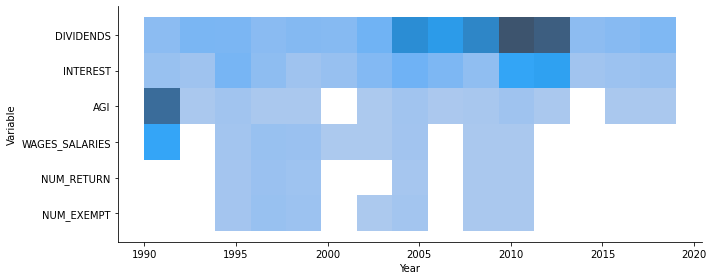

In [89]:
plt.figure(figsize=(12, 8))
sns.displot(data=outlier_info_df, x="YEAR", y="COL", height=4, aspect=20/8)

plt.xlabel("Year")
plt.ylabel("Variable")

In [26]:
population = pd.read_csv(DATA_DIR + "population/population_clustered.csv")
population

,YEAR,GEOFIPS,SEX,POPULATION,AVERAGE_AGE
0,1989,1001,1,16273,32.611227
1,1989,1001,2,17174,35.259695
2,1989,1003,1,46059,36.287968
3,1989,1003,2,48784,38.589804
4,1989,1005,1,11823,33.851603
...,...,...,...,...,...
194501,2019,56041,2,9878,38.261794
194502,2019,56043,1,3921,42.507651
194503,2019,56043,2,3803,44.014594
194504,2019,56045,1,3594,43.152476


In [29]:
pop_all = population.groupby(["YEAR", "GEOFIPS"]).sum().reset_index()
pop_all["AVERAGE_AGE"] = pop_all["AVERAGE_AGE"] / 2
pop_all

,YEAR,GEOFIPS,SEX,POPULATION,AVERAGE_AGE
0,1989,1001,3,33447,33.935461
1,1989,1003,3,94843,37.438886
2,1989,1005,3,24939,35.811895
3,1989,1007,3,16101,35.141795
4,1989,1009,3,38209,36.593317
...,...,...,...,...,...
97248,2019,56037,3,41839,37.639575
97249,2019,56039,3,23236,41.168946
97250,2019,56041,3,19974,38.072805
97251,2019,56043,3,7724,43.261122


In [33]:
merged = outlier_info_df.merge(pop_all).drop("SEX", axis=1)
merged

,YEAR,GEOFIPS,COL,VALUE,POPULATION,AVERAGE_AGE
0,2010,48417,DIVIDENDS,322.540984,3341,41.307565
1,2013,54013,INTEREST,-51.607298,7465,43.898700
2,2004,17019,INTEREST,-53.833262,186402,34.199374
3,2006,54015,DIVIDENDS,143.154762,9573,39.764202
4,2003,48421,DIVIDENDS,134.285714,3068,36.124558
...,...,...,...,...,...,...
2503,2017,12029,AGI,182.194918,16465,44.871738
2504,2017,12029,DIVIDENDS,180.474543,16465,44.871738
2505,2018,12029,AGI,-55.471886,16541,44.987356
2506,2004,48415,DIVIDENDS,131.789474,15880,38.564124


In [38]:
merged["LOG_POPLUATION"] = np.log(merged["POPULATION"])
pop_all["LOG_POPLUATION"] = np.log(pop_all["POPULATION"])

(4.0, 16.0)

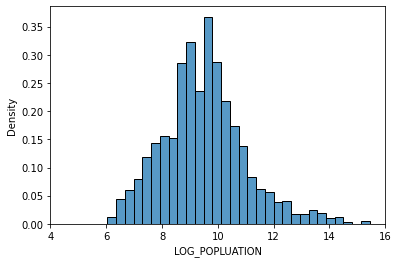

In [51]:
sns.histplot(merged["LOG_POPLUATION"], bins=30, stat="density")
plt.xlim(4, 16)

(4.0, 16.0)

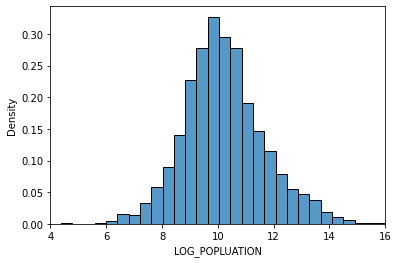

In [52]:
sns.histplot(pop_all["LOG_POPLUATION"], bins=30, stat="density")
plt.xlim(4, 16)

<AxesSubplot:xlabel='YEAR', ylabel='Density'>

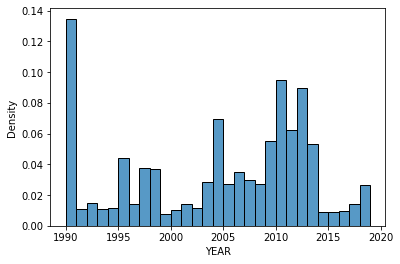

In [73]:
sns.histplot(merged["YEAR"], bins=29, stat="density")

<AxesSubplot:xlabel='YEAR', ylabel='Density'>

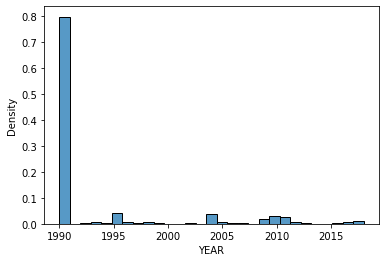

In [74]:
sns.histplot(merged[merged["COL"] == "AGI"]["YEAR"], bins=29, stat="density")

<AxesSubplot:xlabel='YEAR', ylabel='Count'>

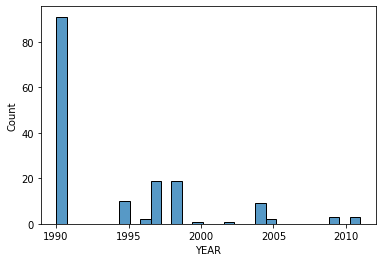

In [75]:
sns.histplot(merged[merged["COL"] == "WAGES_SALARIES"]["YEAR"], bins=29)

<AxesSubplot:xlabel='YEAR', ylabel='Count'>

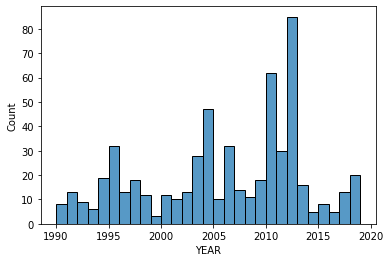

In [76]:
sns.histplot(merged[merged["COL"] == "INTEREST"]["YEAR"], bins=29)

<AxesSubplot:xlabel='YEAR', ylabel='Count'>

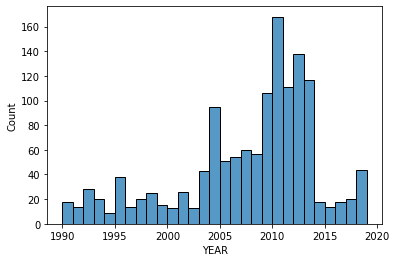

In [77]:
sns.histplot(merged[merged["COL"] == "DIVIDENDS"]["YEAR"], bins=29)

<AxesSubplot:xlabel='YEAR', ylabel='COL'>

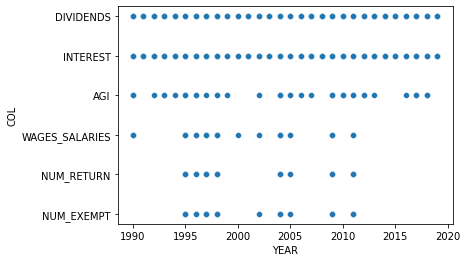

In [78]:
sns.scatterplot(data=outlier_info_df, x="YEAR", y="COL")

In [23]:
assert 1 == 0

AssertionError: 

In [ ]:
data_change[data_change["GEOFIPS"]==51031]

In [ ]:
data_change = data_change[np.invert(data_change["GEOFIPS"].isin(outlier_geofips))]
data_change.shape